## 1. Importing important price data
<p>In this notebook, I'll explore time series of food prices in Rwanda from the <a href="https://data.humdata.org/dataset/wfp-food-prices">United Nations Humanitarian Data Exchange Global Food Price Database</a>. Agriculture makes up over 30% of Rwanda's economy, and over 60% of its export earnings (<a href="https://www.cia.gov/library/publications/the-world-factbook/geos/rw.html">CIA World Factbook</a>), so the price of food is very important to the livelihood of many Rwandans.</p>
<p>In this notebook, we're going to import, manipulate, visualize and forecast Rwandan potato price data. We'll also wrap our analysis into functions to make it easy to analyze prices of other foods.</p>

In [21]:
# Load the readr and dplyr packages
suppressMessages(library(readr))
suppressMessages(library(dplyr))

# Import the potatoes dataset
potato_prices <- read_csv('datasets/Potatoes (Irish).csv', col_types=cols())

# Take a glimpse at the contents
glimpse(potato_prices)

Rows: 4,320
Columns: 18
$ adm0_id            <dbl> 205, 205, 205, 205, 205, 205, 205, 205, 205, 205...
$ adm0_name          <chr> "Rwanda", "Rwanda", "Rwanda", "Rwanda", "Rwanda"...
$ adm1_id            <dbl> 21973, 21973, 21973, 21973, 21973, 21973, 21973,...
$ adm1_name          <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", ...
$ mkt_id             <dbl> 1045, 1045, 1045, 1045, 1045, 1045, 1045, 1045, ...
$ mkt_name           <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Bir...
$ cm_id              <dbl> 148, 148, 148, 148, 148, 148, 148, 148, 148, 148...
$ cm_name            <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoe...
$ cur_id             <dbl> 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, ...
$ cur_name           <chr> "RWF", "RWF", "RWF", "RWF", "RWF", "RWF", "RWF",...
$ pt_id              <dbl> 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, ...
$ pt_name            <chr> "Retail", "Retail", "Retail", "Retail", "Retail"...
$ um_id              <dbl> 5

## 2. Data Manipulation
<p>Many of the columns in the potato data aren't very useful for our analysis. For example, the <code>adm1_name</code> column is always <code>"Rwanda"</code>, and <code>cur_name</code> is always <code>"RWF"</code>. (This is short for Rwandan Franc; for context, 1000 RWF is a little over 1 USD.) Similarly, we don't really need any of the ID columns or the data source.</p>
<p>Even the columns we do need have slightly obscure names. For example, <code>adm1_id</code> isn't as clear as <code>region</code>, and <code>mkt_name</code> isn't as clear as <code>market</code>. So I'll rename variables first is to avoid possible misunderstanding. </p>

In [23]:
# Import again, only reading specific columns
potato_prices <- read_csv('datasets/Potatoes (Irish).csv', 
                          col_types=cols_only(
                          adm1_name=col_character(),
                          mkt_name=col_character(),
                          cm_name=col_character(),
                          mp_month=col_number(),
                          mp_year=col_number(),
                          mp_price=col_number()))

# Rename the columns to be more informative
potato_prices_renamed <- potato_prices %>% rename(
                         region=adm1_name,
                         market=mkt_name,
                         commodity_kg=cm_name,
                         month=mp_month,
                         year=mp_year,
                         price_rwf=mp_price)

# Check the result
glimpse(potato_prices_renamed)

Rows: 4,320
Columns: 6
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ month        <dbl> 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3...
$ year         <dbl> 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2011, 2011, ...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...


## 3. Data Cleaning
<p>As is often the case in a data analysis, the data we are given isn't in quite the form we'd like it to be. For example, in the last task the month and year were given as integers. Since we'll be performing some time series analysis, it would be helpful if they were provided as dates. Before we can analyze the data, we need to clean it.</p>

In [25]:
# Load lubridate
suppressMessages(library(lubridate))

# Convert year and month to Date
potato_prices_cleaned <- potato_prices_renamed %>%
                         mutate(date=ymd(paste(year,month,'01')))%>%
                         select(-4:-5)


# See the result
glimpse(potato_prices_cleaned)

Rows: 4,320
Columns: 5
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...
$ date         <date> 2010-11-01, 2010-12-01, 2011-01-01, 2011-02-01, 2011-...


## 4. For reproducibility
<p>As versatile as potatoes are, with their ability to be boiled, roasted, mashed, fried, or chipped, the people of Rwanda have more varied culinary tastes. So we might need to look at some other types and for reproducibility, we'll write functions to avoid cut and paste errors and have more readable code.</p>

In [27]:
# Wrap this code into a function
read_price_data = function(commodity){
    
data_file <- paste0('datasets/',commodity,'.csv')
prices <- read_csv(
  data_file,
  col_types = cols_only(
    adm1_name = col_character(),
    mkt_name = col_character(),
    cm_name = col_character(),
    mp_month = col_integer(),
    mp_year = col_integer(),
    mp_price = col_double()
  )
)

prices_renamed <- prices %>% 
  rename(
    region = adm1_name, 
    market = mkt_name,
    commodity_kg = cm_name,
    month = mp_month,
    year = mp_year,
    price_rwf = mp_price
  )

potato_prices_renamed %>% 
  mutate(
    date = ymd(paste(year, month, "01"))
  ) %>% 
  select(-month, -year)
    
}

# Test it
pea_prices <- read_price_data('Peas (fresh)')
glimpse(pea_prices)

Rows: 4,320
Columns: 5
$ region       <chr> "$West/Iburengerazuba", "$West/Iburengerazuba", "$West...
$ market       <chr> "Birambo", "Birambo", "Birambo", "Birambo", "Birambo",...
$ commodity_kg <chr> "Potatoes (Irish)", "Potatoes (Irish)", "Potatoes (Iri...
$ price_rwf    <dbl> 157.0000, 133.3333, 96.5000, 97.0000, 107.8000, 125.50...
$ date         <date> 2010-11-01, 2010-12-01, 2011-01-01, 2011-02-01, 2011-...


## 5. Plotting the price of potatoes
<p>To see how those prices change over time, we'll use a line plot to explore.</p>

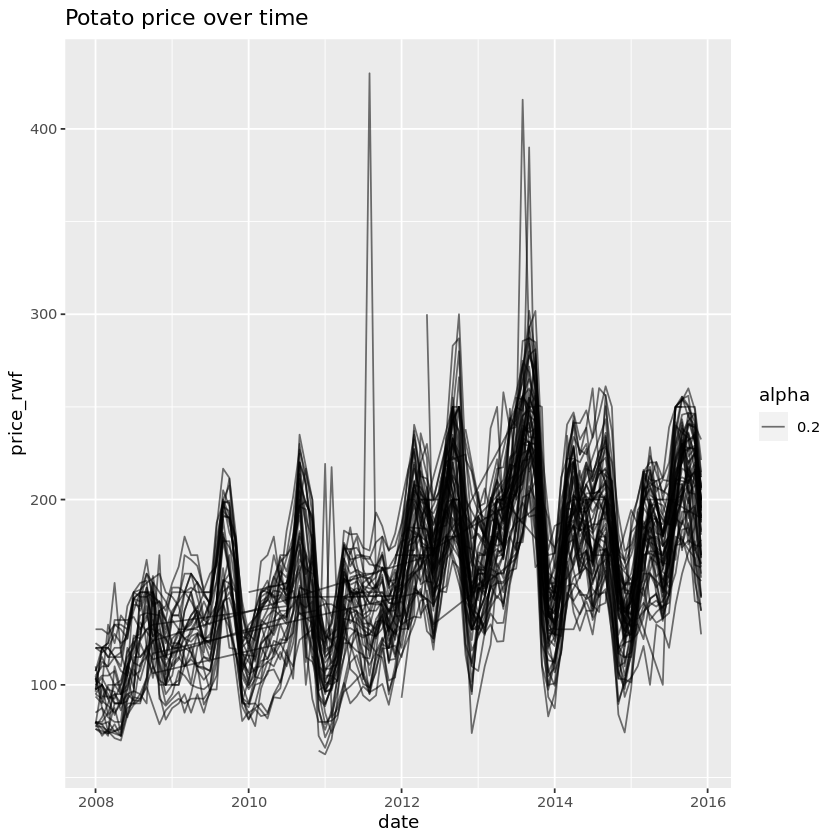

In [29]:
# Load ggplot2
suppressMessages(library(ggplot2))

# Draw a line plot of price vs. date grouped by market 
ggplot(potato_prices_cleaned, aes(date, price_rwf, group=market))+
geom_line(aes(alpha=0.2))+
ggtitle('Potato price over time')

## 6. Wrapping plotting code into function
<p>There is a bit of a trend in the potato prices, with them increasing until 2013, after which they level off. More striking though is the seasonality: the prices are lowest around December and January, and have a peak around August. Some years also show a second peak around April or May.</p>
<p>Just as with the importing and cleaning code, if we want to make lots of similar plots, we need to wrap the plotting code into a function.</p>

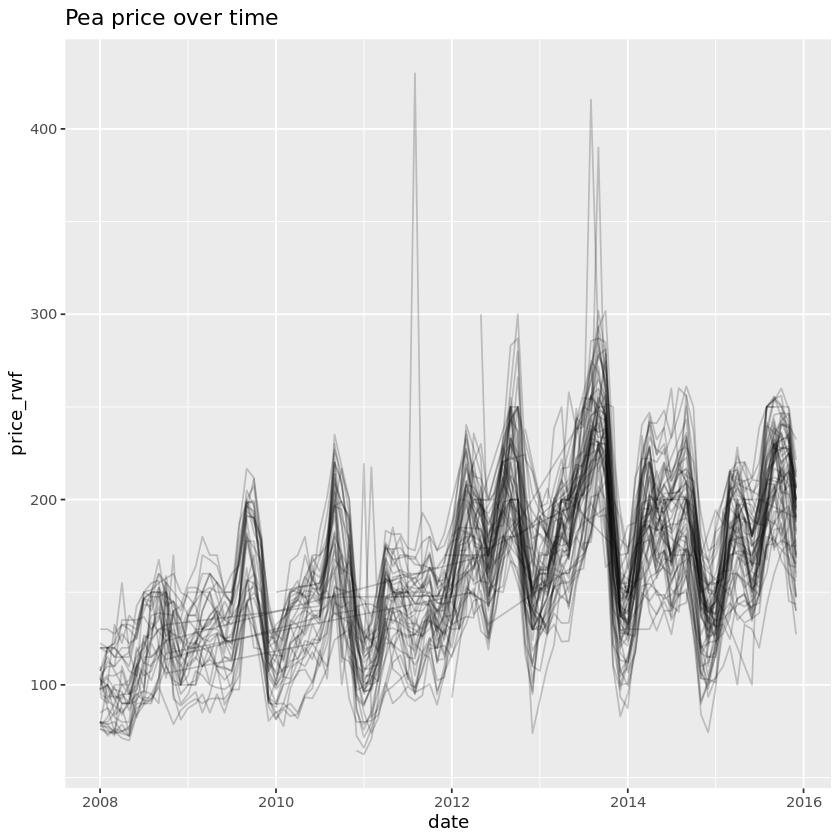

In [31]:
# Wrap this code into a function
plot_price_vs_time = function(prices, commodity) {
prices %>% 
  ggplot(aes(date, price_rwf, group = market)) +
  geom_line(alpha = 0.2) +
  ggtitle(paste(commodity,"price over time"))
}

# Try the function on the pea data
plot_price_vs_time(pea_prices, 'Pea')

## 7. Preparing to predict the future (part 1)
<p>While it's useful to see how the prices have changed in the past, what's more exciting is to forecast how they will change in the future. Before we get to that, there are some data preparation steps that need to be performed.</p>
<p>The datasets for each commodity are very rich: rather than being a single time series, they consist of a time series for each market. The fancy way of analyzing these is to treat them as a single hierarchical time series. The easier way, that we'll try here, is to take the average price across markets at each time and analyze the resulting single time series.</p>
<p>Looking at the plots from the potato and pea datasets, we can see that occasionally there is a big spike in the price. That probably indicates a logistic problem where that food wasn't easily available at a particular market, or the buyer looked like a tourist and got ripped off. The consequence of these outliers is that it is a bad idea to use the <em>mean</em> price of each time point: instead, the <em>median</em> makes more sense since it is robust against outliers. Thus, we'll use median price across markets to analyze time series. </p>

In [33]:
# Group by date, and calculate the median price
potato_prices_summarized <- potato_prices_cleaned %>%
                              group_by(date) %>%
                              summarise(median_price_rwf=median(price_rwf))

# See the result
potato_prices_summarized

`summarise()` ungrouping output (override with `.groups` argument)


date,median_price_rwf
<date>,<dbl>
2008-01-01,97.5000
2008-02-01,100.0000
2008-03-01,95.0000
2008-04-01,96.2500
2008-05-01,95.0000
2008-06-01,110.0000
2008-07-01,116.6667
2008-08-01,125.0000
2008-09-01,136.2500


## 8. Preparing to predict the future (part 2)
<p>Before we can start forecasting, the last preparation work is to convert our summarized dataset into a <code>ts</code> object.</p>

In [35]:
# Load magrittr
library(magrittr)

# Extract a time series
potato_time_series <- potato_prices_summarized %$% ts(
                      median_price_rwf, 
                      start=c(year(min(date)), month(min(date))),
                      end=c(year(max(date)), month(max(date))),
                      frequency=12
                      )


# See the result
potato_time_series

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2008,97.5000,100.0000,95.0000,96.2500,95.0000,110.0000,116.6667,125.0000,136.2500,130.0000,127.5000,114.3750
2009,120.0000,122.5000,130.0000,131.2500,135.0000,124.3125,125.8333,144.2500,181.2500,170.0000,150.2500,112.0000
2010,109.6875,113.5000,131.2500,132.0833,140.4167,147.3750,142.5000,161.5000,182.4000,162.5000,151.5000,122.5000
2011,105.7000,108.1750,118.8750,145.0143,148.6667,148.0500,137.4048,137.2619,141.6667,144.2000,133.1750,141.5000
2012,150.7500,175.2500,186.0139,186.2500,182.5000,162.7500,179.1250,196.9643,226.5000,203.5000,169.2500,144.0000
2013,154.3333,157.0000,171.2500,187.5000,177.0000,202.2500,210.0000,233.1875,241.3333,237.5000,176.7083,140.0000
2014,138.3333,158.7500,186.2500,198.2500,191.0000,189.3333,182.5000,187.6191,200.0000,183.1310,150.0000,133.9286
2015,136.2500,157.6071,178.0000,190.2778,179.3750,168.3333,180.0000,202.1250,223.5000,217.5000,216.1250,190.0000


## 9. Make data preparation easy again
<p>Now again, wrap the data preparation code into a function.</p>

In [37]:
# Wrap this code into a function
create_price_time_series = function(prices) {
prices_summarized <- prices %>%
  group_by(date) %>% 
  summarize(median_price_rwf = median(price_rwf))

time_series <- prices_summarized %$% 
  ts(
    median_price_rwf, 
    start = c(year(min(date)), month(min(date))), 
    end   = c(year(max(date)), month(max(date))), 
    frequency = 12
  )
}

# Try the function on the pea data
pea_time_series <- create_price_time_series(pea_prices)
pea_time_series 

`summarise()` ungrouping output (override with `.groups` argument)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2008,97.5000,100.0000,95.0000,96.2500,95.0000,110.0000,116.6667,125.0000,136.2500,130.0000,127.5000,114.3750
2009,120.0000,122.5000,130.0000,131.2500,135.0000,124.3125,125.8333,144.2500,181.2500,170.0000,150.2500,112.0000
2010,109.6875,113.5000,131.2500,132.0833,140.4167,147.3750,142.5000,161.5000,182.4000,162.5000,151.5000,122.5000
2011,105.7000,108.1750,118.8750,145.0143,148.6667,148.0500,137.4048,137.2619,141.6667,144.2000,133.1750,141.5000
2012,150.7500,175.2500,186.0139,186.2500,182.5000,162.7500,179.1250,196.9643,226.5000,203.5000,169.2500,144.0000
2013,154.3333,157.0000,171.2500,187.5000,177.0000,202.2500,210.0000,233.1875,241.3333,237.5000,176.7083,140.0000
2014,138.3333,158.7500,186.2500,198.2500,191.0000,189.3333,182.5000,187.6191,200.0000,183.1310,150.0000,133.9286
2015,136.2500,157.6071,178.0000,190.2778,179.3750,168.3333,180.0000,202.1250,223.5000,217.5000,216.1250,190.0000


## 10. Predicting future potato prices
<p>All the preparation is done and we are ready to start forecasting. Since both the potato and the pea data had strong seasonality (for example, potatoes were most expensive around August and cheapest around December), for agricultural data, a good forecast should show a similar shape throughout the seasons.</p>

         Point Forecast     Lo 80    Hi 80     Lo 95    Hi 95
Jan 2016       190.0093 171.35706 208.6615 161.48317 218.5354
Feb 2016       202.6099 174.14582 231.0740 159.07783 246.1420
Mar 2016       220.0317 181.72222 258.3413 161.44238 278.6211
Apr 2016       231.5932 184.48380 278.7026 159.54559 303.6408
May 2016       226.2626 174.20438 278.3209 146.64641 305.8789
Jun 2016       229.1587 170.73454 287.5829 139.80665 318.5108
Jul 2016       230.8787 166.57270 295.1848 132.53113 329.2263
Aug 2016       251.1739 175.53815 326.8096 135.49902 366.8487
Sep 2016       279.3573 189.13187 369.5827 141.36943 417.3451
Oct 2016       262.7887 172.33073 353.2467 124.44516 401.1323
Nov 2016       236.0485 149.89274 322.2042 104.28465 367.8123
Dec 2016       205.0924 126.05584 284.1290  84.21640 325.9684
Jan 2017       205.0036 121.88813 288.1190  77.88948 332.1177
Feb 2017       218.4941 125.58323 311.4050  76.39917 360.5891
Mar 2017       237.1698 131.67270 342.6669  75.82591 398.5137
Apr 2017

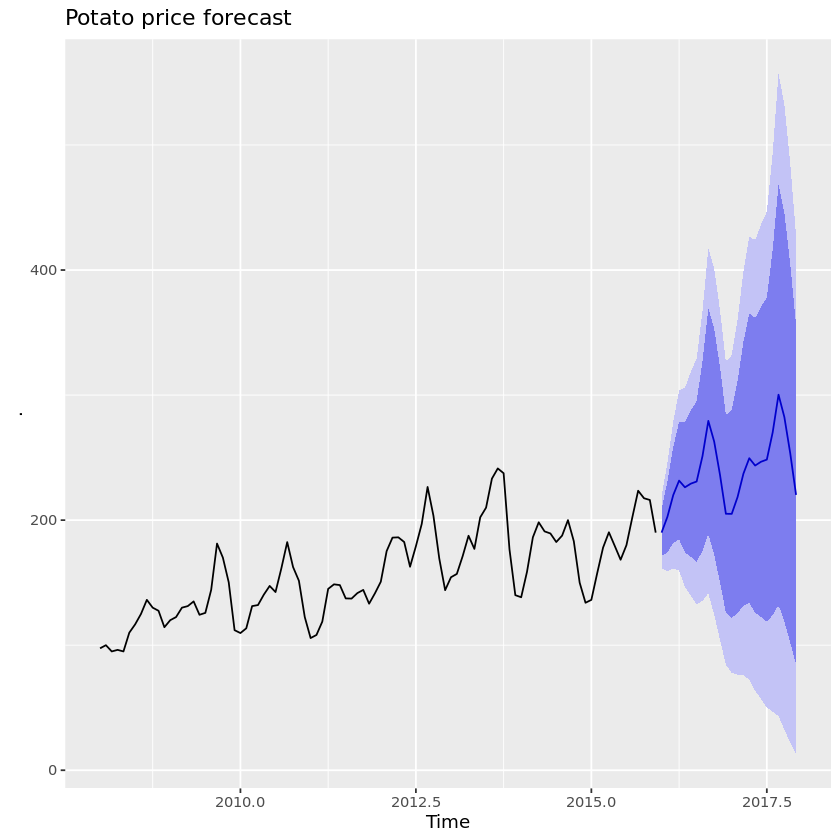

In [39]:
# Load forecast
library(forecast)

# Forecast the potato time series
potato_price_forecast <- potato_time_series %>% forecast()

# View it
potato_price_forecast

# Plot the forecast
autoplot(potato_price_forecast, main='Potato price forecast')

## 11. The final function
<p>The forecast shows the spike in potato prices in late summer and the dip toward the end of the year.</p>
<p>With this analysis step, just as the previous steps, to make things repeatable, we will wrap the code into a function.</p>

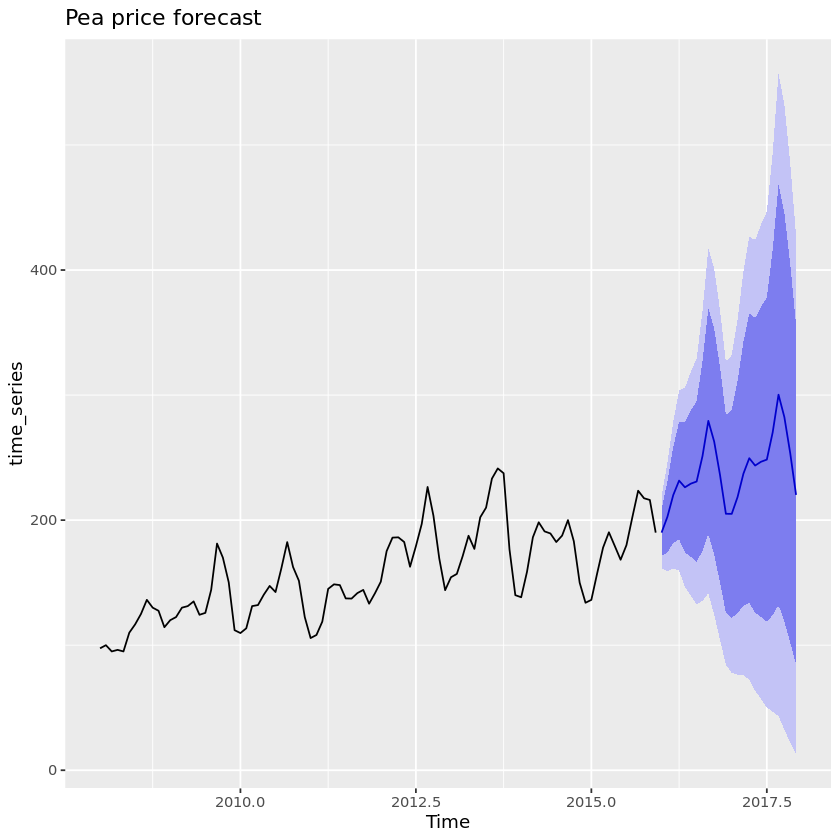

In [41]:
# Wrap the code into a function
plot_price_forecast = function(time_series, commodity) {
price_forecast <- forecast(time_series)
autoplot(price_forecast, main = paste(commodity,"price forecast"))
}

# Try the function on the pea data
plot_price_forecast(pea_time_series,'Pea')

## 12. Do it all over again
<p>Since we have wrapped all the code into functions, now we can easily take a look at any other food type - Beans.</p>

`summarise()` ungrouping output (override with `.groups` argument)


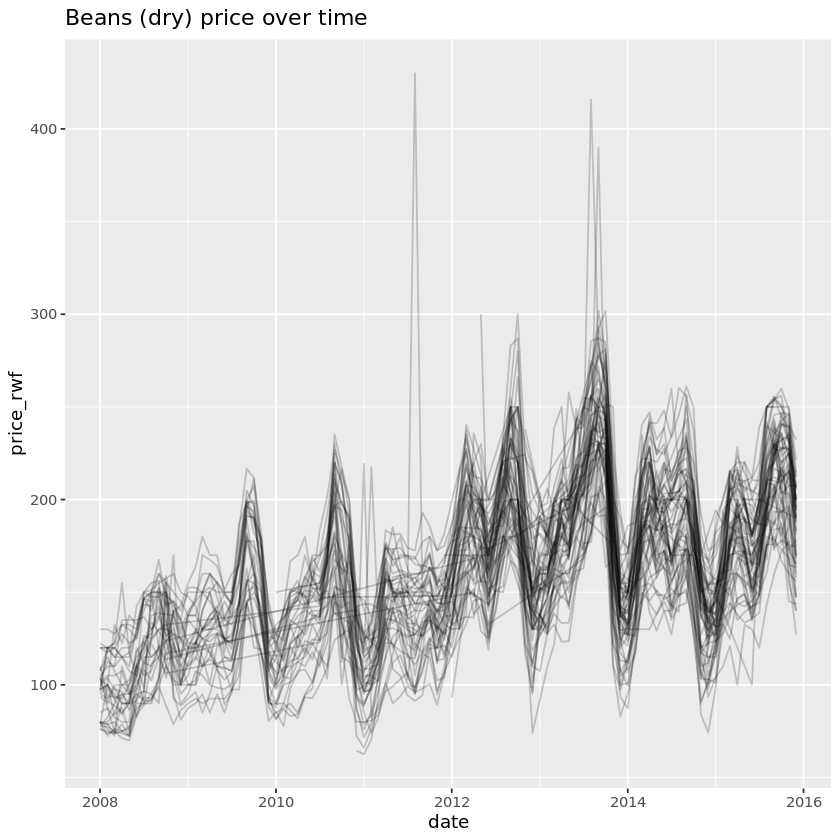

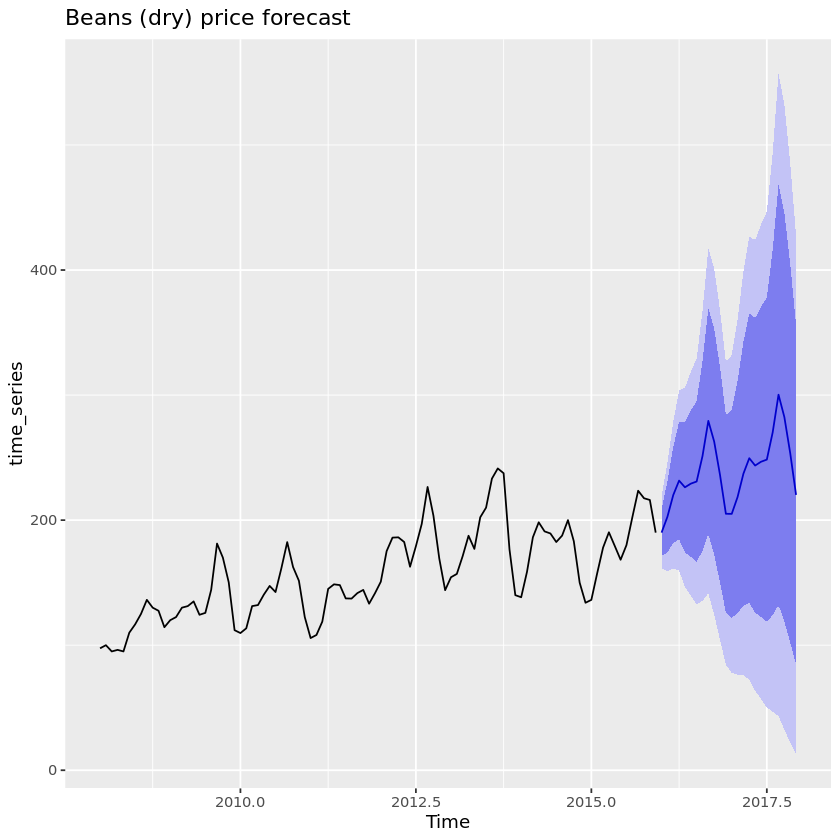

In [43]:
# Choose dry beans as the commodity
commodity <- "Beans (dry)"

# Read the price data
bean_prices <- read_price_data(commodity)

# Plot price vs. time
plot_price_vs_time(bean_prices, commodity)

# Create a price time series
bean_time_series <- create_price_time_series(bean_prices)

# Plot the price forecast
plot_price_forecast(bean_time_series, commodity)